In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random.seed(42)

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3  # Context length: How many characters do we take to predict the next one.

In [7]:
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [8]:
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters (Trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers (Trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # Batch mean
            xvar = x.var(0, keepdim=True) # Batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # Update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


In [10]:
# Initialize model

n_embd = 10         # The dimensionality of the character embedding vectors
n_hidden = 100      # The number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # Last layer: make softmax less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1 # If using BatchNorm then affect this parameter as it iteractes with multiplication of the function.
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # Distribution is good for tanh when gain is set to 5/3 - Refer to Activation Distribution Histogram

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [11]:
epochs = 200000
batch_size = 32

# Metriccs
lossi = []
ud = []

# Training loop
for i in range(epochs):

    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y

    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # Concatenate the vectos
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #Loss function
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: Would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01 # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # # Metrics
    if i % 10000 == 0:
        print(f'{i:7d} / {epochs:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        # Track standard deviation of the update, divided by log of the data (content) std of that parameter
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i > 10000:
        break # AFTER DEBUG: Obviously disable
    

      0 /  200000: 3.287031
  10000 /  200000: 2.357845


layer 2 (      Tanh) | mean -0.00 | std 0.63 | saturated: 4.22%
layer 5 (      Tanh) | mean -0.02 | std 0.66 | saturated: 4.81%
layer 8 (      Tanh) | mean -0.01 | std 0.66 | saturated: 4.41%
layer 11 (      Tanh) | mean +0.00 | std 0.67 | saturated: 3.06%
layer 14 (      Tanh) | mean -0.00 | std 0.68 | saturated: 2.91%


Text(0.5, 1.0, 'Activation Distribution')

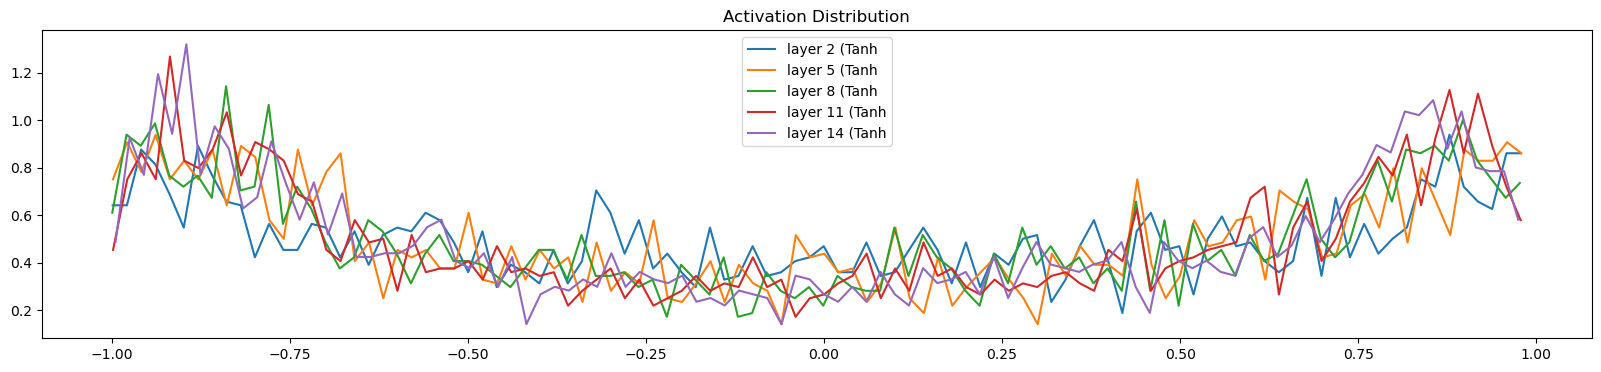

In [12]:
# Visualize histograms of forward pass activations
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Exclude the output (softmax) layer
    if isinstance(layer, Tanh): # Inspect Tanh layer as it has finite range (-1, 1) and easy to visualize
        t = layer.out
        print('layer %d (%10s) | mean %+.2f | std %.2f | saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation Distribution')

layer 2 (      Tanh) | mean -0.000000 | std 3.468695e-03
layer 5 (      Tanh) | mean -0.000000 | std 3.297559e-03
layer 8 (      Tanh) | mean +0.000000 | std 2.979777e-03
layer 11 (      Tanh) | mean +0.000000 | std 2.925413e-03
layer 14 (      Tanh) | mean -0.000000 | std 2.907665e-03


Text(0.5, 1.0, 'Gradient Distribution')

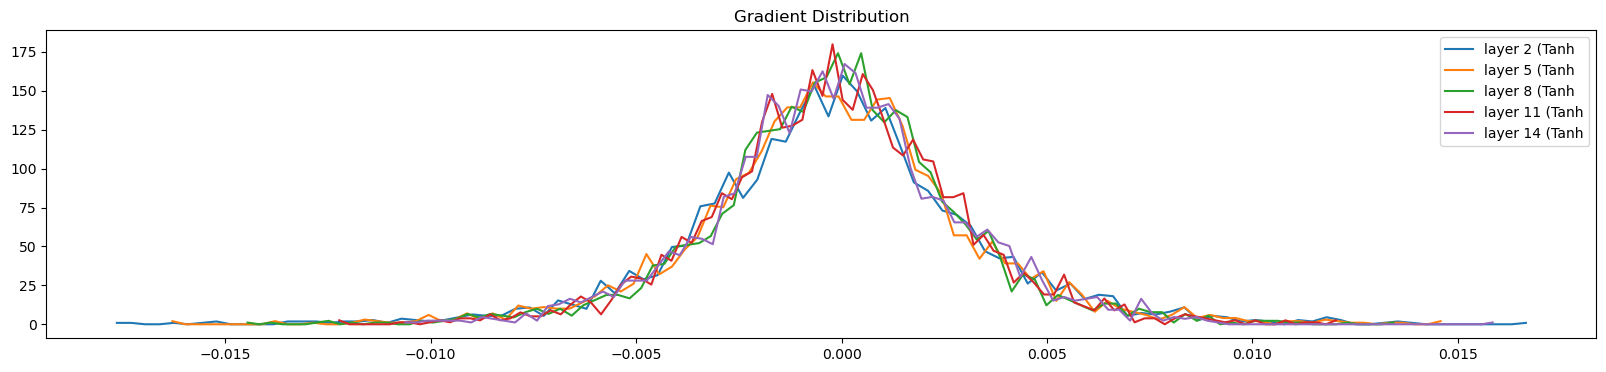

In [13]:
# Visualize histograms of backward pass gradients
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # Exclude the output (softmax) layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s) | mean %+f | std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('Gradient Distribution')


weight   (27, 10) | mean +0.000000 | std 1.170586e-02 | grad:data ratio 1.163645e-02
weight  (30, 100) | mean +0.000129 | std 8.749070e-03 | grad:data ratio 2.716708e-02
weight (100, 100) | mean +0.000063 | std 6.419299e-03 | grad:data ratio 3.607672e-02
weight (100, 100) | mean -0.000012 | std 5.957725e-03 | grad:data ratio 3.360593e-02
weight (100, 100) | mean +0.000105 | std 5.472113e-03 | grad:data ratio 3.114012e-02
weight (100, 100) | mean +0.000007 | std 5.033347e-03 | grad:data ratio 2.880900e-02
weight  (100, 27) | mean -0.000028 | std 9.609325e-03 | grad:data ratio 5.015344e-02


Text(0.5, 1.0, 'Weights  Gradient Distribution')

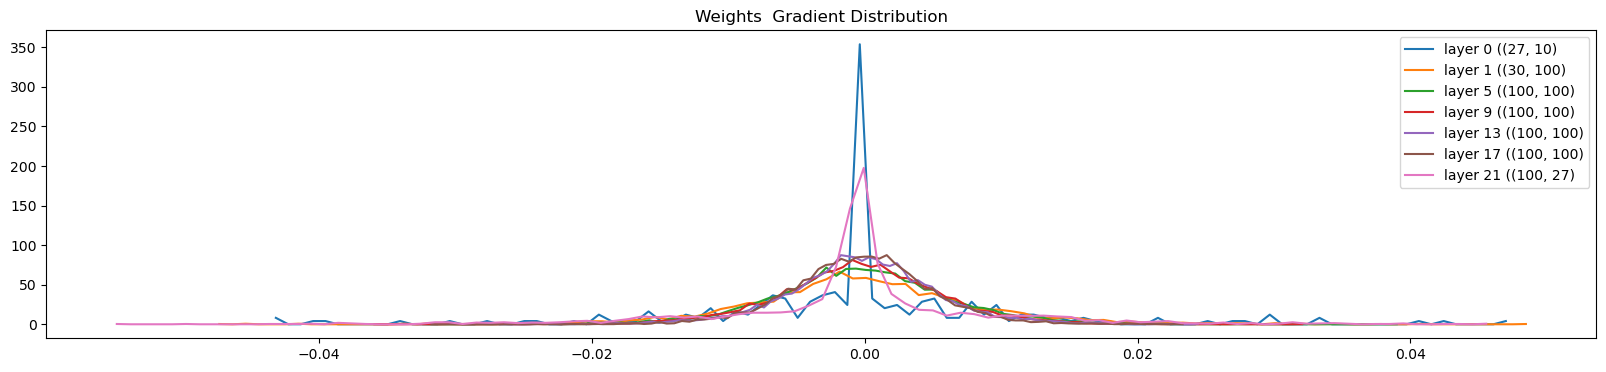

In [14]:
# Visualize histograms weight gradient distribution
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, p in enumerate(parameters): # Exclude the output (softmax) layer
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights  Gradient Distribution')


Text(0.5, 1.0, 'Update to data ratio')

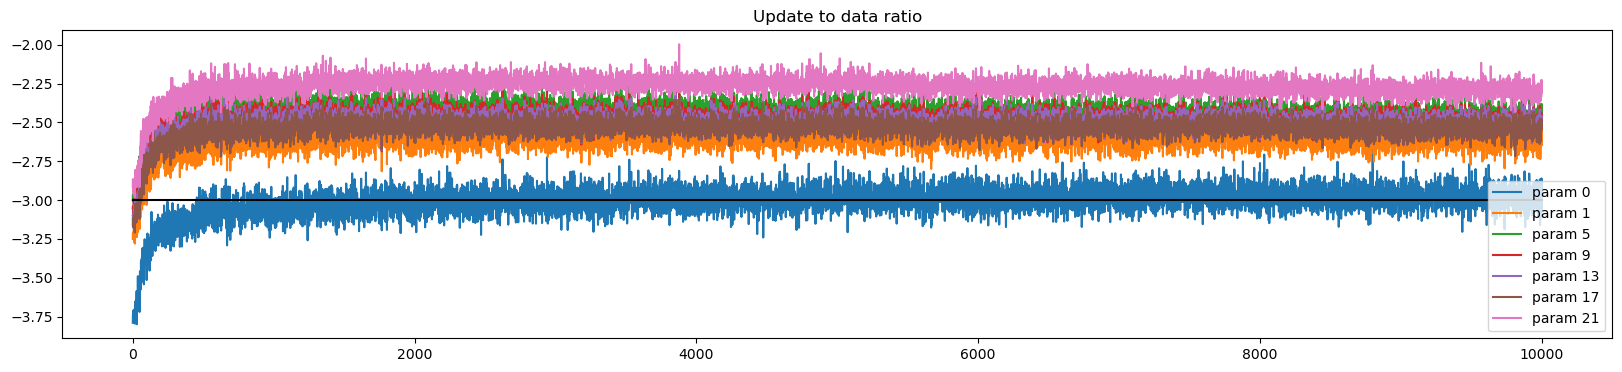

In [15]:
# Visualize histogram of deviation update to data - Good to spot root problems hidden by BatchNorm
# A rough heuristic of -3 on the log scale is a good range for ratio. If param are below or above line, learning rate is too slow or fast.
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # These ratios should be ~1e-3, indicated on plot (Black line).
plt.legend(legends)
plt.title('Update to data ratio')

In [16]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # Concat into (N, block_size * nembd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [17]:
split_loss('train')
split_loss('val')

train 2.205500364303589
val 2.2145919799804688
